In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import keras
from keras import ops

import keras_cv

/Users/thibaultheintz/miniconda3/envs/CV/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# showing some example images 
image0 = np.load('train/img/train_2.npy')
mask0 = np.load('train/seg/train_2.npy')
image0.shape



(500, 332, 3)

# Some examples

We plot some exampels and their associated labels. 

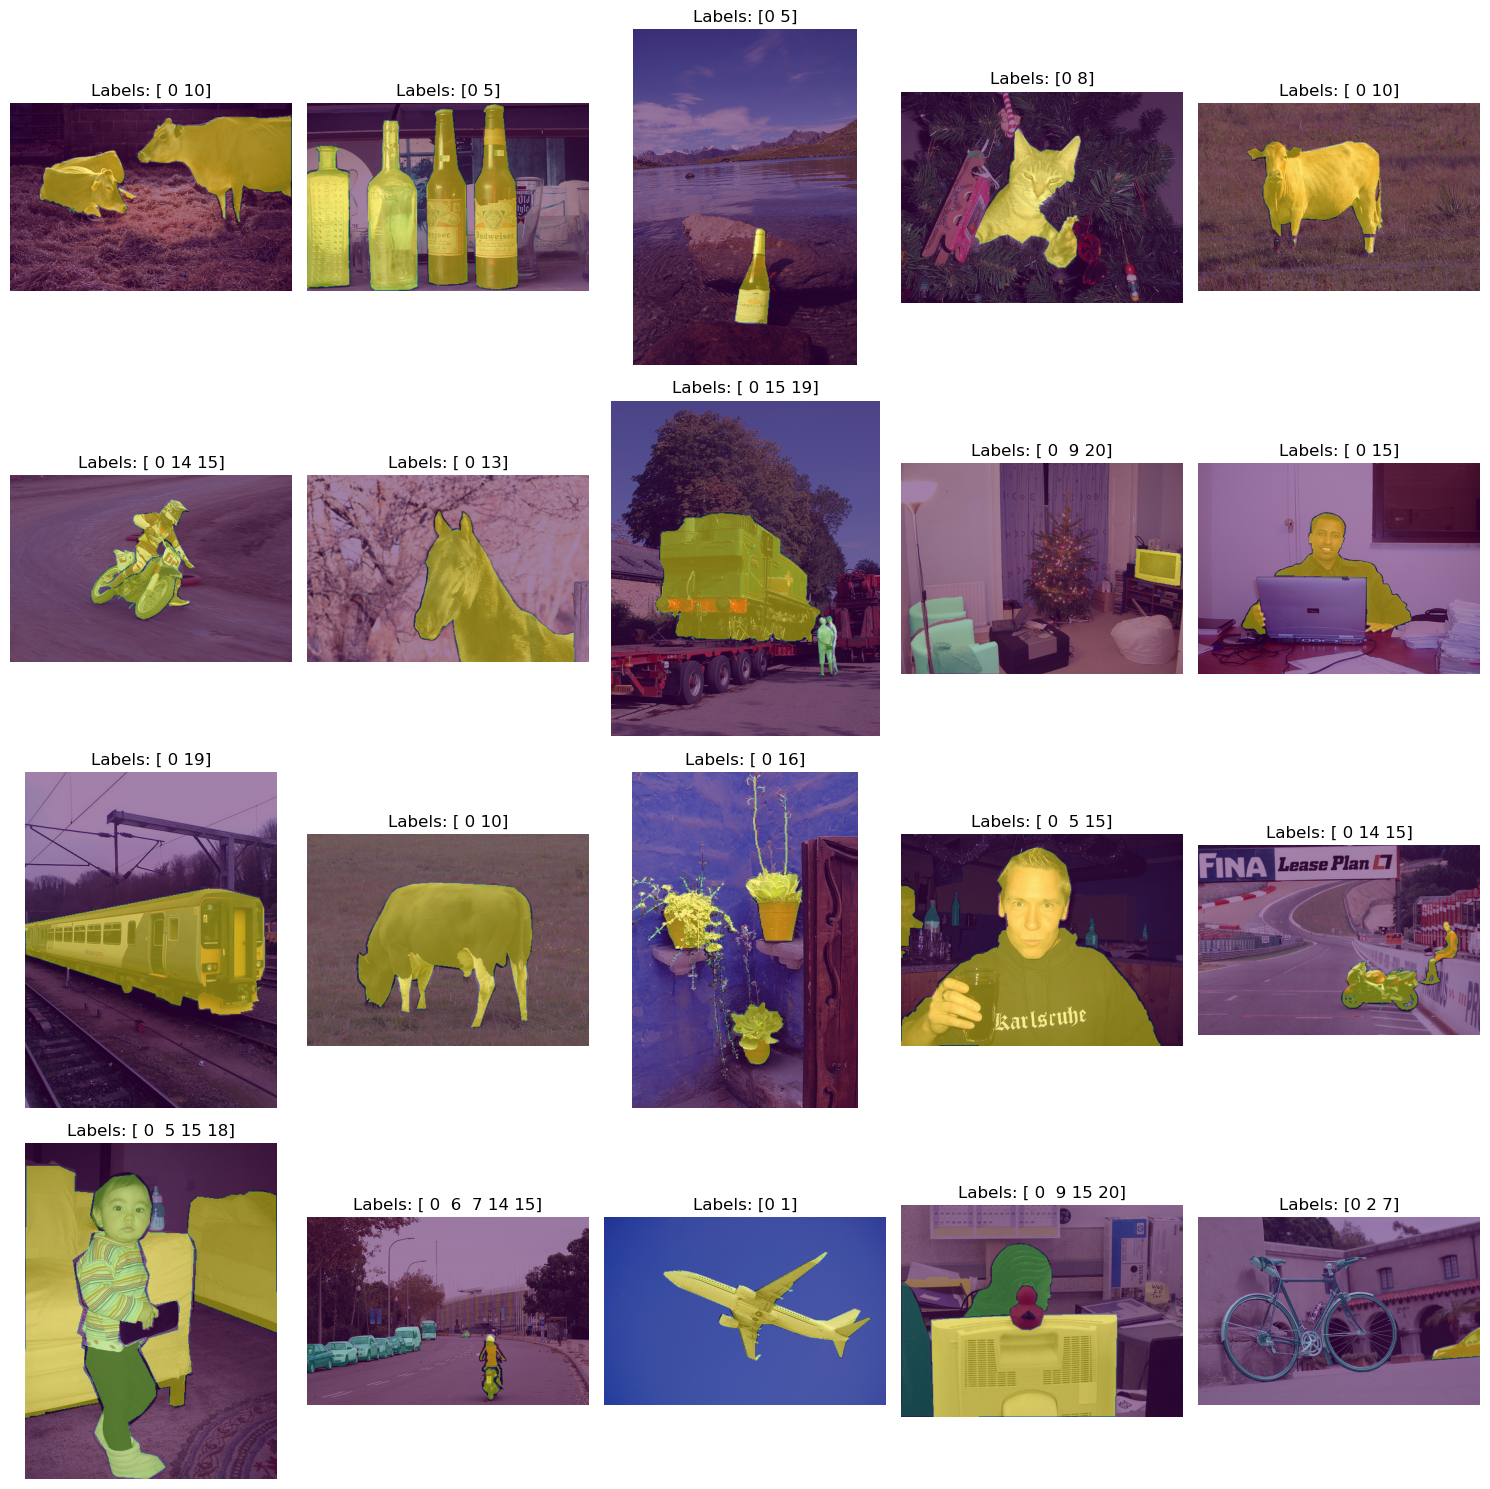

In [3]:
import matplotlib.pyplot as plt

num_images = 20
num_rows = 4
num_cols = num_images // num_rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i in range(num_images):
    # Get the image for the current loop iteration
    img = np.load(f'train/img/train_{i}.npy')
    mask = np.load(f'train/seg/train_{i}.npy')
    
    # Calculate the row and column index for the current image
    row_idx = i // num_cols
    col_idx = i % num_cols
    labels = np.unique(mask)
    # Plot the image
    axes[row_idx, col_idx].imshow(img)
    axes[row_idx, col_idx].imshow(mask, alpha=0.5)
    axes[row_idx, col_idx].axis('off')
    axes[row_idx, col_idx].set_title(f'Labels: {labels}')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


# plt.imshow(image0)
# plt.imshow(mask0, alpha=0.5)





# Making a dataset class

In [4]:
# getting a list of all files
img_files = [f for f in os.listdir("train/img") if not f.startswith(".")]

n = len(img_files)

train_files, validation_files = train_test_split(img_files, test_size=0.2, random_state=42)
test_files = [f for f in os.listdir("test/img") if not f.startswith(".")]   

In [5]:
class SegmentationDataset(tf.keras.utils.PyDataset):
    def __init__(self, img_folder,seg_folder, file_list, batch_size=32, image_size=(256, 256),  **kwargs ):
        super().__init__(**kwargs)
        self.img_folder = img_folder
        self.seg_folder = seg_folder
        self.batch_size = batch_size
        self.image_size = image_size
        self.img_files = file_list
        self.num_samples = len(self.img_files)
        
    def __len__(self):
        return int(np.ceil(self.num_samples / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_img_files = self.img_files[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_imgs = []
        batch_segs = []
        
        for img_file in batch_img_files:
            img_path = os.path.join(self.img_folder, img_file)
            seg_path = os.path.join(self.seg_folder, img_file)
            
            img = np.load(img_path, allow_pickle=True)
            seg = np.load(seg_path, allow_pickle=True)
            seg = tf.expand_dims(seg, axis=-1)
            
            img = resize(img, self.image_size)
            seg = resize(seg, self.image_size, anti_aliasing=False)
            
            seg = tf.keras.utils.to_categorical(seg, num_classes=21) #if np.max(seg) < 21 else seg
            # seg = np.argmax(seg, axis=-1)                         This line completely removes the predicted class dimension, i commented it out otherwise code doesn't work
            batch_imgs.append(img)
            batch_segs.append(seg)
        
        return (np.array(batch_imgs), np.array(batch_segs))
    

img_folder = "train/img"
seg_folder = "train/seg"
test_folder = "test/img"
batch_size = 8
image_size = (256, 256)

train_dataset = SegmentationDataset(img_folder=img_folder, seg_folder=seg_folder, batch_size=batch_size, image_size=image_size, file_list=train_files)
val_dataset = SegmentationDataset(img_folder=img_folder, seg_folder=seg_folder, batch_size=batch_size, image_size=image_size, file_list=validation_files)


In [37]:
train_dataset[0][0].shape, train_dataset[0][1].shape


((8, 256, 256, 3), (8, 256, 256, 21))

In [40]:
val_dataset[0][0].shape, val_dataset[0][1].shape

((8, 256, 256, 3), (8, 256, 256, 21))

### how the data comes out of the segmentation dataset
Getting 1 batch from the dataset, we get batch of images and a corresponding batch of segmentations. Notice that the class labels are encoded as a vector, with size equal to number of classes. 

In [29]:
print(f'Shape of the images in batch 0: {train_dataset[0][0].shape}')
print(f'Shape of the segmentations in batch 0: {train_dataset[0][1].shape}')


Shape of the images in batch 0: (8, 256, 256, 3)
Shape of the segmentations in batch 0: (8, 256, 256, 21)


In [8]:
import os 
class TestDataset(tf.keras.utils.Sequence):
    def __init__(self, img_folder, file_list, batch_size=32, image_size=(256, 256)):
        self.img_folder = img_folder
        self.batch_size = batch_size
        self.image_size = image_size
        self.img_files = file_list
        self.num_samples = len(self.img_files)
        
    def __len__(self):
        return int(np.ceil(self.num_samples / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_img_files = self.img_files[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_imgs = []
        
        for img_file in batch_img_files:
            img_path = os.path.join(self.img_folder, img_file)
            
            img = np.load(img_path, allow_pickle=True)
            img = resize(img, self.image_size)
            
            batch_imgs.append(img)
        
        return np.array(batch_imgs)

# Assuming you have a list of test files and the test images are in the 'test/img' folder
test_img_folder = "test/img"
test_files = [f for f in os.listdir(test_img_folder) if not f.startswith(".")]


# A pretrained example

This is an example of a model pretrained with pascal VOC, we are using this data for training and it is therefore not representative! This is just an illustration.

In [9]:
model = keras_cv.models.DeepLabV3Plus.from_preset(
    "deeplab_v3_plus_resnet50_pascalvoc",
    num_classes=21,
    input_shape=[256, 256, 3],
)


In [10]:
image = np.load(f'train/img/train_{i}.npy')
resize_keras = keras_cv.layers.Resizing(height=256, width=256)
image = resize_keras(image)
image = keras.ops.expand_dims(np.array(image), axis=0)
image.shape # for image prediction, it is first transformed to a tensor with a batch dimension (the first dimension)


TensorShape([1, 256, 256, 3])

In [11]:
probs = model(image)
probs.shape 

TensorShape([1, 256, 256, 21])

In [12]:
argmax_probs = np.argmax(probs, axis=-1)
argmax_probs.shape  #now selecting the class with the highest probability for each pixel

(1, 256, 256)

In [13]:
preds = ops.expand_dims(argmax_probs, axis=-1)  #needs a last dimension for visualization

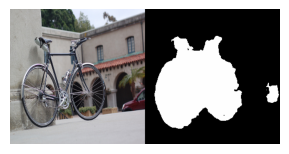

In [14]:
keras_cv.visualization.plot_segmentation_mask_gallery(
        image,
        value_range=(0, 255),
        num_classes=1,
        y_true=None,
        y_pred=preds,
        scale=3,
        rows=1,
        cols=1,
    )

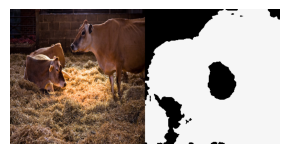

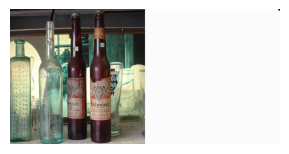

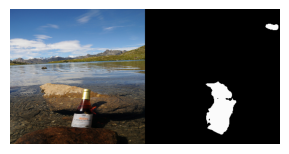

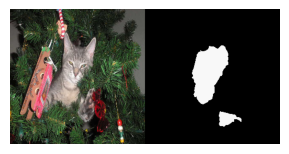

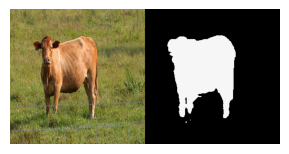

In [15]:

for i in range(5):
    image = np.load(f'train/img/train_{i}.npy')

    resize = keras_cv.layers.Resizing(height=256, width=256)
    image = resize(image)
    image = keras.ops.expand_dims(np.array(image), axis=0)
    preds = ops.expand_dims(ops.argmax(model(image), axis=-1), axis=-1)
    keras_cv.visualization.plot_segmentation_mask_gallery(
        image,
        value_range=(0, 255),
        num_classes=1,
        y_true=None,
        y_pred=preds,
        scale=3,
        rows=1,
        cols=1,
    )


# Now, a fair model

Now we pick a pretrained model, but not pretrained using pascal voc, but rather imagenet, a very famous image classification dataset.

In [16]:
from keras_cv.datasets.pascal_voc.segmentation import load as load_voc

In [31]:
train_ds = load_voc(split="sbd_train")

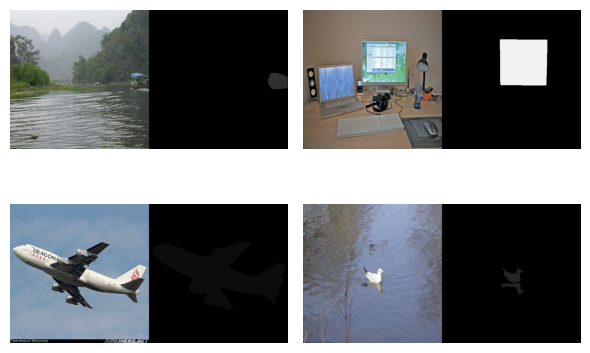

In [38]:
def preprocess_tfds_inputs(inputs):
    def unpackage_tfds_inputs(tfds_inputs):
        return {
            "images": tfds_inputs["image"],
            "segmentation_masks": tfds_inputs["class_segmentation"],
        }

    outputs = inputs.map(unpackage_tfds_inputs)
    outputs = outputs.map(keras_cv.layers.Resizing(height=512, width=512))
    outputs = outputs.batch(4, drop_remainder=True)
    return outputs


train_ds = preprocess_tfds_inputs(train_ds)
batch = train_ds.take(1).get_single_element()
keras_cv.visualization.plot_segmentation_mask_gallery(
    batch["images"],
    value_range=(0, 255),
    num_classes=21,  # The number of classes for the oxford iiit pet dataset. The VOC dataset also includes 1 class for the background.
    y_true=batch["segmentation_masks"],
    scale=3,
    rows=2,
    cols=2,
)



In [39]:
train_ds

<_BatchDataset element_spec={'images': TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), 'segmentation_masks': TensorSpec(shape=(4, 512, 512, 1), dtype=tf.uint8, name=None)}>

In [35]:
train_ds.take(1).get_single_element().keys()

dict_keys(['image', 'class_segmentation', 'object_segmentation'])

In [56]:
batch_size = 8
image_size = (256, 256)
classes = 21
lr = 1e-3
epochs = 10


In [57]:
model = keras_cv.models.DeepLabV3Plus.from_preset(
    "resnet50_v2_imagenet", num_classes=classes
)


In [58]:
optimizer = keras.optimizers.SGD(learning_rate=lr, weight_decay=0.0001, momentum=0.9)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
meanIoU = keras.metrics.MeanIoU(num_classes=classes, sparse_y_true=False, sparse_y_pred=False)

model.compile(optimizer=optimizer,
    loss=loss,
    metrics=[meanIoU, keras.metrics.CategoricalAccuracy()],
)